In [1]:
# Import modules
import numpy as np
import pandas as pd
import spiceypy as sp
from astroquery.jplsbdb import SBDB
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

KM2AU = sp.convrt(1, "km", "au")
AU2KM = sp.convrt(1, "au", "km")
R2D = sp.dpr()
D2R = sp.rpd()

# Import the SPICE meta kernel file
sp.furnsh('kernel_meta.txt')

# Set the date-time of the Asteroid Day (yeah)
T0_ET = sp.utc2et('2020-06-30T00:00:00')

# https://astroquery.readthedocs.io/en/latest/api/astroquery.jplsbdb.SBDBClass.html#astroquery.jplsbdb.SBDBClass.query
# https://ssd-api.jpl.nasa.gov/doc/sbdb.html#cov for full_precision, covariance, solution_epoch.
# No need to use "orbit" when covariance="mat", so just extract "covariance"
# NOTE: ["orbit"]["epoch"] != ["orbit"]["covariance"]["epoch"]
#   (latter == JPL HORIZONS epoch from solution_epoch=True, I guess)
_q = SBDB.query('2020JX1', full_precision=True, covariance="mat")["orbit"]["covariance"]
epoch_jx1 = _q["epoch"]
cov_jx1_sbdb = _q["data"]
cov_labels = _q["labels"]
elt_jx1_sbdb = _q["elements"]
# Only save elements in the unit compatible with the covariance matrix
elt_jx1_sbdb = dict(
    e=elt_jx1_sbdb["e"],
    q=elt_jx1_sbdb["q"].to_value("au"),
    tp=elt_jx1_sbdb["tp"].to_value("d"),
    node=elt_jx1_sbdb["om"].to_value("deg"),
    peri=elt_jx1_sbdb["w"].to_value("deg"),
    i=elt_jx1_sbdb["i"].to_value("deg")
)

# Define the GM of the Sun
GM_SUN = sp.bodvcd(bodyid=10, item='GM', maxn=1)[1][0]

print("Solution epoch:", epoch_jx1)
print(f"covariance in the order of {cov_labels}")
print("Elements at epoch:\n", elt_jx1_sbdb)

Solution epoch: 2458992.5 d
covariance in the order of ['e', 'q', 'tp', 'node', 'peri', 'i']
Elements at epoch:
 {'e': 0.2934119101944594, 'q': 1.006038036616504, 'tp': 2459038.685060509, 'node': 274.5862121265418, 'peri': 12.80835719940099, 'i': 3.547597067710438}


In [2]:
# Sample using covariance matrix
_sample = pd.DataFrame(
    np.random.multivariate_normal(list(elt_jx1_sbdb.values()), cov_jx1_sbdb, size=10000),
    columns=cov_labels
)
_sample["M0"] = 0.0  # We will use tp as EPOCH and therefore M0 = 0.0

# Convert units for SPICE
sample = _sample.copy()
sample["q"] *= AU2KM
for c in ["node", "peri", "i", "M0"]:
    sample[c] *= D2R
sample["epoch_et"] = [sp.str2et(f"JD{_e}") for _e in _sample["tp"]]
sample = sample[["q", "e", "i", "node", "peri", "M0", "tp"]].values  # order of SPICE conics
_sample

,e,q,tp,node,peri,i,M0
0,0.293409,1.006038,2.459039e+06,274.586200,12.808376,3.547566,0.0
1,0.293405,1.006038,2.459039e+06,274.586285,12.808302,3.547527,0.0
2,0.293425,1.006038,2.459039e+06,274.586143,12.808366,3.547712,0.0
3,0.293408,1.006038,2.459039e+06,274.586219,12.808387,3.547563,0.0
4,0.293406,1.006038,2.459039e+06,274.586207,12.808368,3.547542,0.0
...,...,...,...,...,...,...,...
9995,0.293412,1.006038,2.459039e+06,274.586183,12.808379,3.547594,0.0
9996,0.293414,1.006038,2.459039e+06,274.586203,12.808409,3.547617,0.0
9997,0.293420,1.006038,2.459039e+06,274.586181,12.808397,3.547667,0.0
9998,0.293423,1.006038,2.459039e+06,274.586199,12.808346,3.547700,0.0


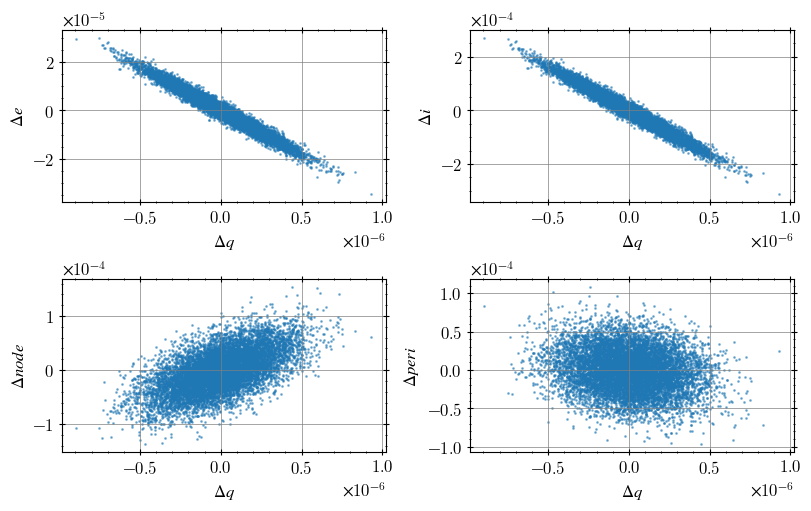

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

for _ax, (x, y) in zip(axs.flat, [("q", "e"), ("q", "i"), ("q", "node"), ("q", "peri")]):
    _ax.scatter(_sample[x] - elt_jx1_sbdb[x], _sample[y] - elt_jx1_sbdb[y], s=1, alpha=0.5)
    _ax.set(xlabel=r"$Δ{}$".format(x), ylabel=r"$Δ{}$".format(y))

plt.show();

In [4]:
# Calculate the position at T0_ET for the samples
pos_sample = np.array([sp.conics([*_s, GM_SUN], et=T0_ET)[:3] for _s in sample])
pos_earth, _lt = sp.spkpos("EARTH", T0_ET, "J2000", abcorr="NONE", obs="SUN")
pos_sample_rel = pos_sample - pos_earth
pos_sample_rel

array([[51275531.95087823,  5945011.94120565, 63729769.59120224],
       [51434686.40634315,  6024487.50255507, 63739943.77992754],
       [50625093.30062659,  5622059.02043603, 63688140.82277098],
       ...,
       [50829763.9777882 ,  5723369.66843422, 63701236.48599064],
       [50686867.20409681,  5652601.51152188, 63692087.94839475],
       [50786119.87192044,  5701748.37555444, 63698432.77811591]])

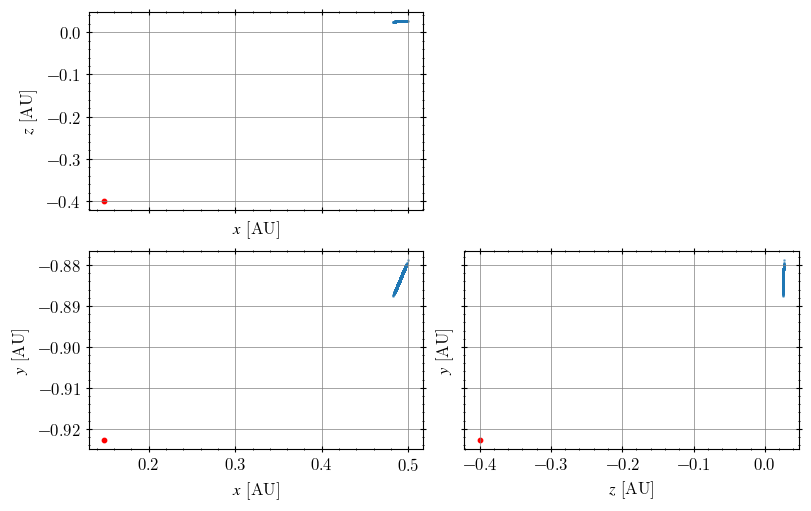

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex="col", sharey="row")

axs[0, 1].axis("off")

axs[0, 0].scatter(pos_sample[:, 0]*KM2AU, pos_sample[:, 2]*KM2AU, s=1, alpha=0.5)
axs[0, 0].scatter(pos_earth[0]*KM2AU, pos_earth[2]*KM2AU, s=10, c="r")
axs[0, 0].set(xlabel=r"$x$ [AU]", ylabel=r"$z$ [AU]")

axs[1, 0].scatter(pos_sample[:, 0]*KM2AU, pos_sample[:, 1]*KM2AU, s=1, alpha=0.5)
axs[1, 0].scatter(pos_earth[0]*KM2AU, pos_earth[1]*KM2AU, s=10, c="r")
axs[1, 0].set(xlabel=r"$x$ [AU]", ylabel=r"$y$ [AU]")

axs[1, 1].scatter(pos_sample[:, 2]*KM2AU, pos_sample[:, 1]*KM2AU, s=1, alpha=0.5)
axs[1, 1].scatter(pos_earth[2]*KM2AU, pos_earth[1]*KM2AU, s=10, c="r")
axs[1, 1].set(xlabel=r"$z$ [AU]", ylabel=r"$y$ [AU]")


plt.show();

In [6]:
# Let's compute the largest deviation / distance of the re-sampled position
# vector by using the scipy function cdist
from scipy.spatial.distance import cdist

DIST_MAT = cdist(np.array(list(ast_2020_jx1_df['POS_VEC_KM'].values)), \
                 np.array(list(ast_2020_jx1_df['POS_VEC_KM'].values)))

# Print the maximum distance of all position solution space / domain
print('Maximum distance of the predicted positions of 2020 JX1 in km: ' \
      f'{np.max(DIST_MAT)}')
print('\n')

NameError: name 'ast_2020_jx1_df' is not defined

In [9]:
# We want to compute the ecliptic coordinates of the asteroid as seen from
# Earth ... or let's say: the solution space
# First, we need to compute the position vector of our home planet ...
EARTH_POSITION_KM, _ = sp.spkgps(targ=399, et=SAMPLE_ET, \
                                       ref='ECLIPJ2000', obs=10)

In [10]:
# ... to determine the asteroid's position as seen from Earth
ast_2020_jx1_df.loc[:, 'POS_VEC_WRT_EARTH_KM'] = \
    ast_2020_jx1_df['POS_VEC_KM'].apply(lambda x: x - EARTH_POSITION_KM)

In [11]:
# Now let's compute the ecliptic longitude and latitude values
ast_2020_jx1_df.loc[:, 'ECLIP_LONG_DEG'] = \
    ast_2020_jx1_df['POS_VEC_WRT_EARTH_KM'] \
        .apply(lambda x: np.degrees(sp.recrad(x)[1]))
ast_2020_jx1_df.loc[:, 'ECLIP_LAT_DEG'] = \
    ast_2020_jx1_df['POS_VEC_WRT_EARTH_KM'] \
        .apply(lambda x: np.degrees(sp.recrad(x)[2]))

# Print the statistics of the results
print('Statistics for the Ecliptic Longitude: \n' \
      f'{ast_2020_jx1_df["ECLIP_LONG_DEG"].describe()}')
print('\n')
print('Statistics for the Ecliptic Latitude: \n' \
      f'{ast_2020_jx1_df["ECLIP_LAT_DEG"].describe()}')

Statistics for the Ecliptic Longitude: 
count    1000.000000
mean      109.446653
std         0.005297
min       109.428448
25%       109.443164
50%       109.446505
75%       109.450200
max       109.465064
Name: ECLIP_LONG_DEG, dtype: float64


Statistics for the Ecliptic Latitude: 
count    1000.000000
mean       26.973316
std         0.003754
min        26.960134
25%        26.970845
50%        26.973377
75%        26.975816
max        26.985842
Name: ECLIP_LAT_DEG, dtype: float64


In [12]:
# Assignment:
#   1. Visualise the long, lat coordinates in a sky map
#      (see: https://towardsdatascience.com/
#            space-science-with-python-space-maps-747c7d1eaf7f)
#   2. Compute the probability density function in spherical coordinates
#      (and plot it in the sky map. Hint: Use the Haversine metric!)

In [13]:
# Store the data in a csv file
ast_2020_jx1_df.to_csv('2020_JX1_data.csv', sep=';')